## Training with openai 

- References:
    - [Basic intro](https://platform.openai.com/docs/guides/fine-tuning)

- Notes:
    - taking the set of instructions and prompts that you found worked best for the model prior to fine-tuning, and including them in every training example. This should let you reach the best and most general results, especially if you have relatively few (e.g. under a hundred) training examples
    - If you would like to shorten the instructions or prompts that are repeated in every example to save costs, keep in mind that the model will likely behave as if those instructions were included, and it may be hard to get the model to ignore those "baked-in" instructions at inference time. **It may take more training examples to arrive at good results, as the model has to learn entirely through demonstration and without guided instructions.**

In [1]:
import openai

#### Step 1 Data Exploration and Prep

In [89]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import copy
import json

In [28]:
data_folder='/data/home/xiong/data/Fund/CSR'
fintune_data_folder=os.path.join(data_folder,'Fintuning_data','Monetary')
df_train = pd.read_excel(os.path.join(fintune_data_folder,'training2.xlsx'))
df_test = pd.read_excel(os.path.join(fintune_data_folder,'testing2.xlsx'))

In [32]:
def pre_process_stance_info(input_df):
    """ 
    Pre-processes the stance information in the input dataframe.
    Args:
        input_df (pandas.DataFrame): The input dataframe containing the stance information.
    Returns:
        pandas.DataFrame: The pre-processed dataframe with stance information.
    """
    df_stance = pd.DataFrame()
    for tp in ['staff', 'buff']:
        df_temp = input_df[['index', 'Print ISBN', 'country', 'year', tp, '%s_stance_current'%tp, '%s_stance_future'%tp]]
        df_temp = df_temp.rename(columns={tp: 'text'}).rename(columns={c: c.replace(tp+'_', '') for c in df_temp.columns})
        df_temp['type'] = tp
        df_stance = pd.concat([df_stance, df_temp], ignore_index=True)
    
    return df_stance


In [70]:
df_train_stance = pre_process_stance_info(df_train)
df_test_stance = pre_process_stance_info(df_test)

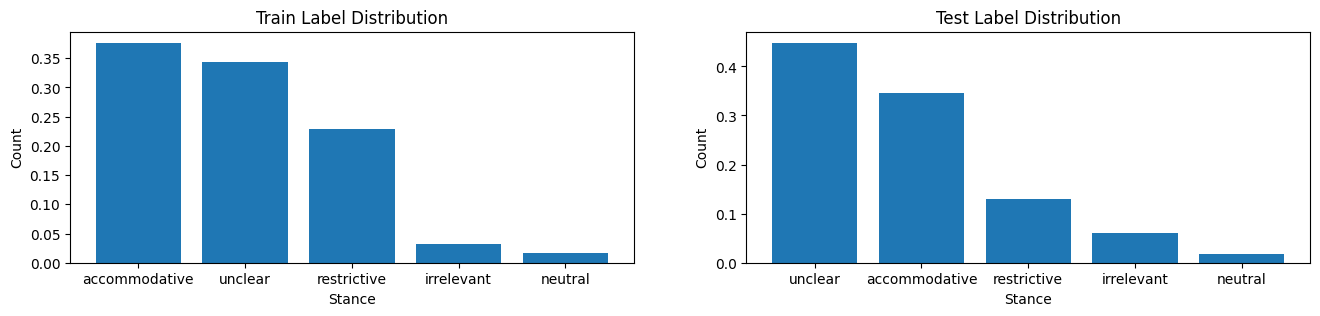

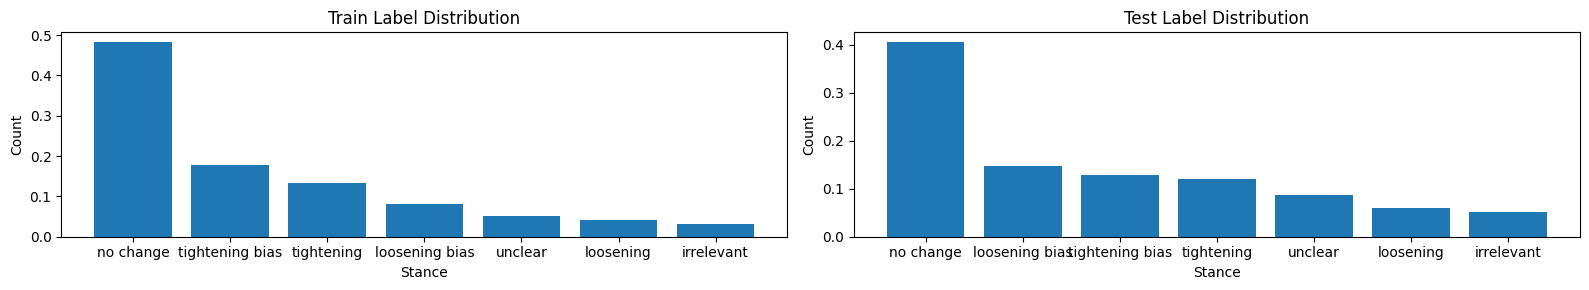

In [51]:
# Plotting the label distribution for 'stance_current' and 'stance_future'
for col in ['stance_current', 'stance_future']:
    # Create subplots
    fig, axs = plt.subplots(1, 2, figsize=(16, 3))
    
    # Calculate label distribution for train and test data
    train_label_distribution = df_train_stance[col].value_counts(normalize=True)
    test_label_distribution = df_test_stance[col].value_counts(normalize=True)
    
    # Plot train label distribution
    axs[0].bar(train_label_distribution.index, train_label_distribution.values)
    axs[0].set_title('Train Label Distribution')
    axs[0].set_xlabel('Stance')
    axs[0].set_ylabel('Count')
    
    # Plot test label distribution
    axs[1].bar(test_label_distribution.index, test_label_distribution.values)
    axs[1].set_title('Test Label Distribution')
    axs[1].set_xlabel('Stance')
    axs[1].set_ylabel('Count')

# Display the plots
plt.tight_layout()
plt.show()

In [84]:
system_prompt_template= '''You are an experience macroeconomist from IMF. 
Given a piece of text concerning a particular country in a given year expressing the views of {TYPE}, complete the following two tasks. 

First, classify the country\'s recent or current monetary policy stance as described in the text into 
**restrictive/neutral/accommodative/unclear/irrelevant**; 
if it discusses monetary policy but the specific stance is not clear, assign unclear; 
if it does not discuss monetary policy, assign irrelevant. 

Second, classify the {TYPE}\'s recommended or planned near-future (next year) direction of change in monetary policy stance 
as described in the text into **tightening/tightening bias/no change/loosening bias/loosening/unclear/irrelevant**; 
if it discusses monetary policy stance but the direction of change is not clear, assign no change; 
if it does not discuss monetary policy stance, assign unclear (if it discusses monetary policy) 
or irrelevant (if it does not discuss monetary policy). 

Return a JSON dict without additional texts as follows: 
```json
{{"stance_current": "<stance_current>", 
"stance_future": "<stance_future>"}}
```
'''
user_prompt_template = '''Country: {COUNTRY}; Year: {YEAR}\nText:\n{TEXT}'''
answer_template = '''{{'stance_current': '{CURRENT}', 'stance_future': '{FUTURE}'}}'''

In [87]:
type_dict = {'staff': 'IMF staff', 'buff': 'country\'s authority'}

In [93]:
def create_messages_from_df(input_df):
    """
    Create messages for the training data from the dataframe.
    Returns:
        list: A list of messages for the training data.
    """
    messages = []
    for index, row in input_df.iterrows():
        # Access the values of each column in the current row
        system_prompt = system_prompt_template.format(TYPE=type_dict[row['type']])
        answer = answer_template.format(CURRENT=row['stance_current'],FUTURE=row['stance_future']) 
        user_prompt = user_prompt_template.format(COUNTRY=row['country'],YEAR=row['year'],TEXT=row['text'])
        message = {"messages":
                    [
                        {   "role": "system",
                            "content": system_prompt},
                        {   "role": "user",
                            "content":  user_prompt},
                        {   "role": "assistant",
                            "content":  answer}
                    ]
                    }
        messages.append(message)
    
    return messages

def messages2jsonl(messages,jsonl_path):
    """
    Create a JSONL file from the messages.
    """
    with open(jsonl_path, 'w') as file:
        for message in messages:
            # Convert dictionary to JSON string and write to file
            file.write(json.dumps(message) + '\n')

In [94]:
#### Create JSONL files for training and testing data
train_messages_path= os.path.join(fintune_data_folder,'train_mon_stance.jsonl')
messages = create_messages_from_df(df_train_stance)
messages2jsonl(messages,train_messages_path)

#### Create JSONL files for test and test data
test_messages_path= os.path.join(fintune_data_folder,'test_mon_stance.jsonl')
messages = create_messages_from_df(df_test_stance)
messages2jsonl(messages,test_messages_path)

#### Validate the JSONL files for openai training

In [104]:
import json
import tiktoken # for token counting
import numpy as np
from collections import defaultdict
import os,sys
sys.path.insert(0,'../libs')
from oai_fintune_utils import load_jsonl,check_format_errors,token_analysis

In [105]:
#### run checks
data_path = train_messages_path
sample_dataset = load_jsonl(data_path,verbose=True)
check_format_errors(sample_dataset)
token_analysis(sample_dataset)

Num examples: 462
First example:
{'role': 'system', 'content': 'You are an experience macroeconomist from IMF. \nGiven a piece of text concerning a particular country in a given year expressing the views of IMF staff, complete the following two tasks. \n\nFirst, classify the country\'s recent or current monetary policy stance as described in the text into \n**restrictive/neutral/accommodative/unclear/irrelevant**; \nif it discusses monetary policy but the specific stance is not clear, assign unclear; \nif it does not discuss monetary policy, assign irrelevant. \n\nSecond, classify the IMF staff\'s recommended or planned near-future (next year) direction of change in monetary policy stance \nas described in the text into **tightening/tightening bias/no change/loosening bias/loosening/unclear/irrelevant**; \nif it discusses monetary policy stance but the direction of change is not clear, assign no change; \nif it does not discuss monetary policy stance, assign unclear (if it discusses mo